In [1]:
!pwd
import netCDF4
import cdsapi

/Users/theoguenais/Desktop/Harvard/Harvard-Classes/hurricast


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from utils import data_processing
from utils import utils_vision_data
import warnings; warnings.simplefilter('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import time 

## Get the data

In [4]:
#First we load the storms we are interested to work with
#Storms are begiining at different wind speeds, 
#so to standardize their beginning I cut them at a min_wind threshold they have to pass.
#Some storms don't have a lot of timesteps so you can specify with min_steps the minimum number of timesteps you want
#Some storms are 40 timesteps, others are 120, etc. So I cut them at a certain number of timesteps
min_wind = 50
min_steps = 20
max_steps= 60
data = utils_vision_data.get_storms(min_wind = min_wind, min_steps = min_steps, max_steps=max_steps, extraction=True, path = './data/ibtracs.last3years.list.v04r00.csv')
#y represents the actual target data we are going to use
#y is of shape storms * timesteps * target features
y, _ = data_processing.prepare_tabular_data_vision(min_wind=min_wind, 
                                                   min_steps=min_steps, 
                                                   max_steps=max_steps)
#Then we get their corresponding vision maps
vision_data = utils_vision_data.extract_vision(data, epsilon = 0.05)

The dictionary of storms has been created.
The trajectories have now been padded.
There are 84 storms with 9 features, and maximum number of steps is 60 and minimum is 60.
The tensor has now been created.
The dictionary of storms has been created.
The trajectories have now been padded.
There are 84 storms with 8 features, and maximum number of steps is 60 and minimum is 60.
The tensor has now been created.


In [7]:
#torch.vision_data
#torch.save(vision_data, './data/vision_data.pt')
#torch.save(y, './data/y.pt')
np.save("data/vision_data.npy", vision_data, allow_pickle=True)
np.save("data/y.npy", y, allow_pickle=True)
#!ls data

In [9]:
vision_data = np.load("data/vision_data.npy", allow_pickle=True)
#np.save("data/y.npy", y, allow_pickle=True)
y = np.load("data/y.npy", allow_pickle=True)

import run 
from run import Prepro
#train_data = prepro.create_targets(8,8)
train_tensors, test_tensors = Prepro.process(vision_data, 
                                y, 
                                0.8,
                                predict_at=8, 
                                window_size=8)

## Let's visualize one example of y to understand its format
#y[0] is the timestamp
#y[1] is latitude
#y[2] is longitude
#y[3] is windspeed (intensity)
#y[4] is pressure
#y[5] is the latitude displacement with previous timestep
#y[6] is longitude displacement with previous timestep2
y[0].shape
vision_data[0].shape

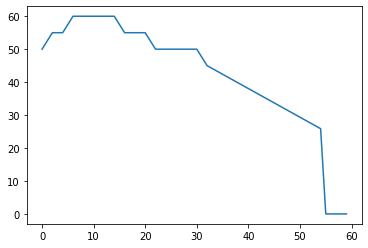

In [7]:
#one important remark: if the number of available timesteps is smaller than a threshold I pad with 0 the end.
#same with the vision data
plt.plot(y[15,:,3])
plt.show()

In [8]:
s = vision_data.shape
print(s)
#s[0] is the storm
#s[1] is the number of timesteps
#s[2] is the value field (geopotential, windspeed u, windspeed v)
#s[3] is the altitude 700, 500, 250
#s[4,5] is the actual map at this timestep, value, and altitude. 1 pixel is 1 degree of latitute and longitude
print("We have {} storms with {} timesteps.".format(s[0], s[1]))

(83, 60, 3, 3, 25, 25)
We have 83 storms with 60 timesteps.


In [9]:
"""for i in range(vision_data.shape[0]):
    image = torch.tensor(vision_data[i][1])
    print("{}: Number of zeros vs number of total elements: {} vs {}".format(i, torch.sum(image==0), image.numel()))
"""


'for i in range(vision_data.shape[0]):\n    image = torch.tensor(vision_data[i][1])\n    print("{}: Number of zeros vs number of total elements: {} vs {}".format(i, torch.sum(image==0), image.numel()))\n'

In [10]:
%matplotlib notebook 

<IPython.core.display.Javascript object>


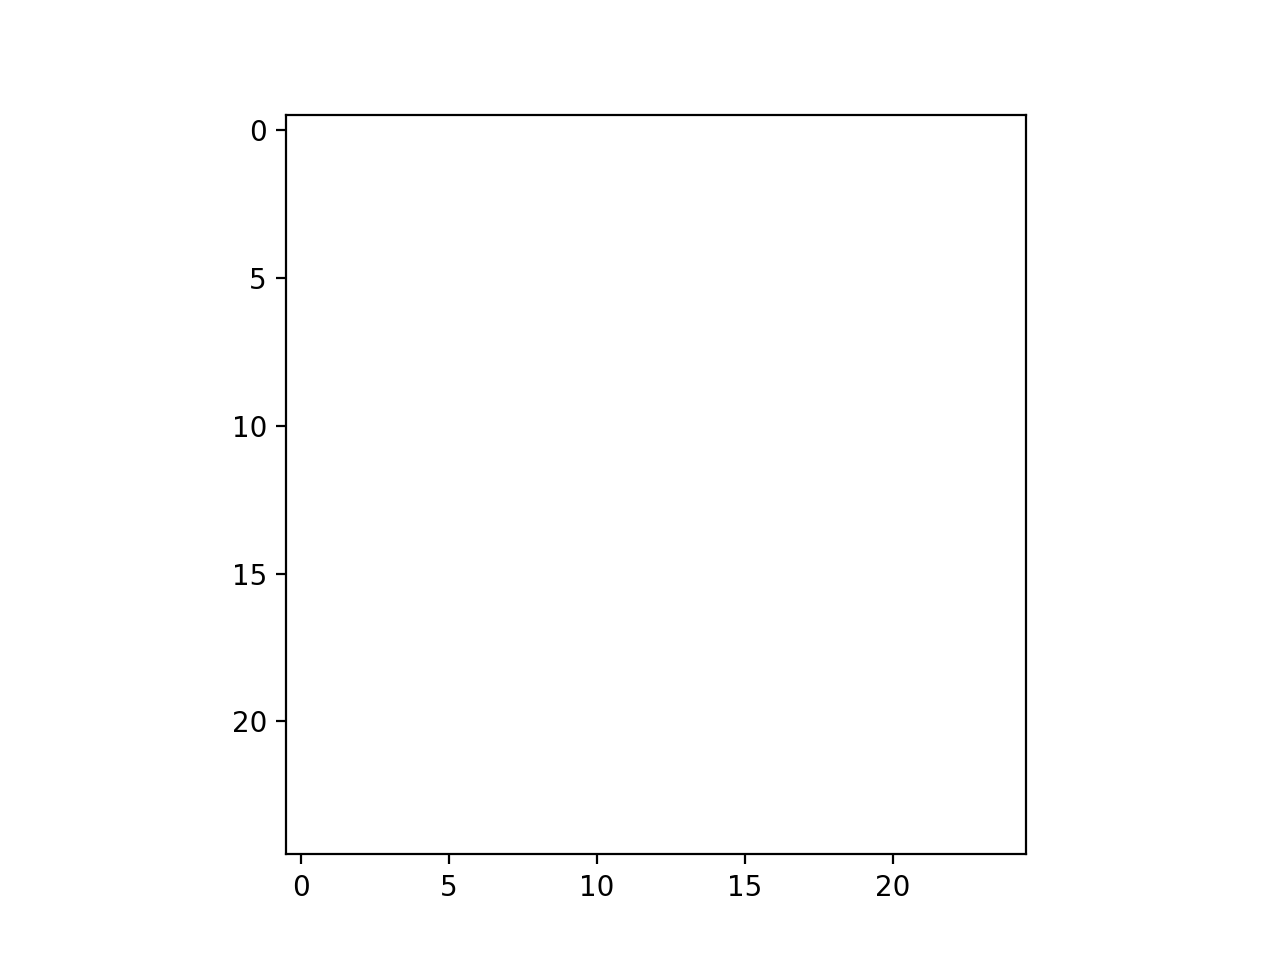

In [11]:
#ani = animate_ouragan(vision_data, 10)
import imp
from utils import plot
imp.reload(plot)
plot.animate_ouragan(vision_data, n=6)

In [12]:
vision_data[0].shape

(60, 3, 3, 25, 25)

## Visualize one map

<IPython.core.display.Javascript object>


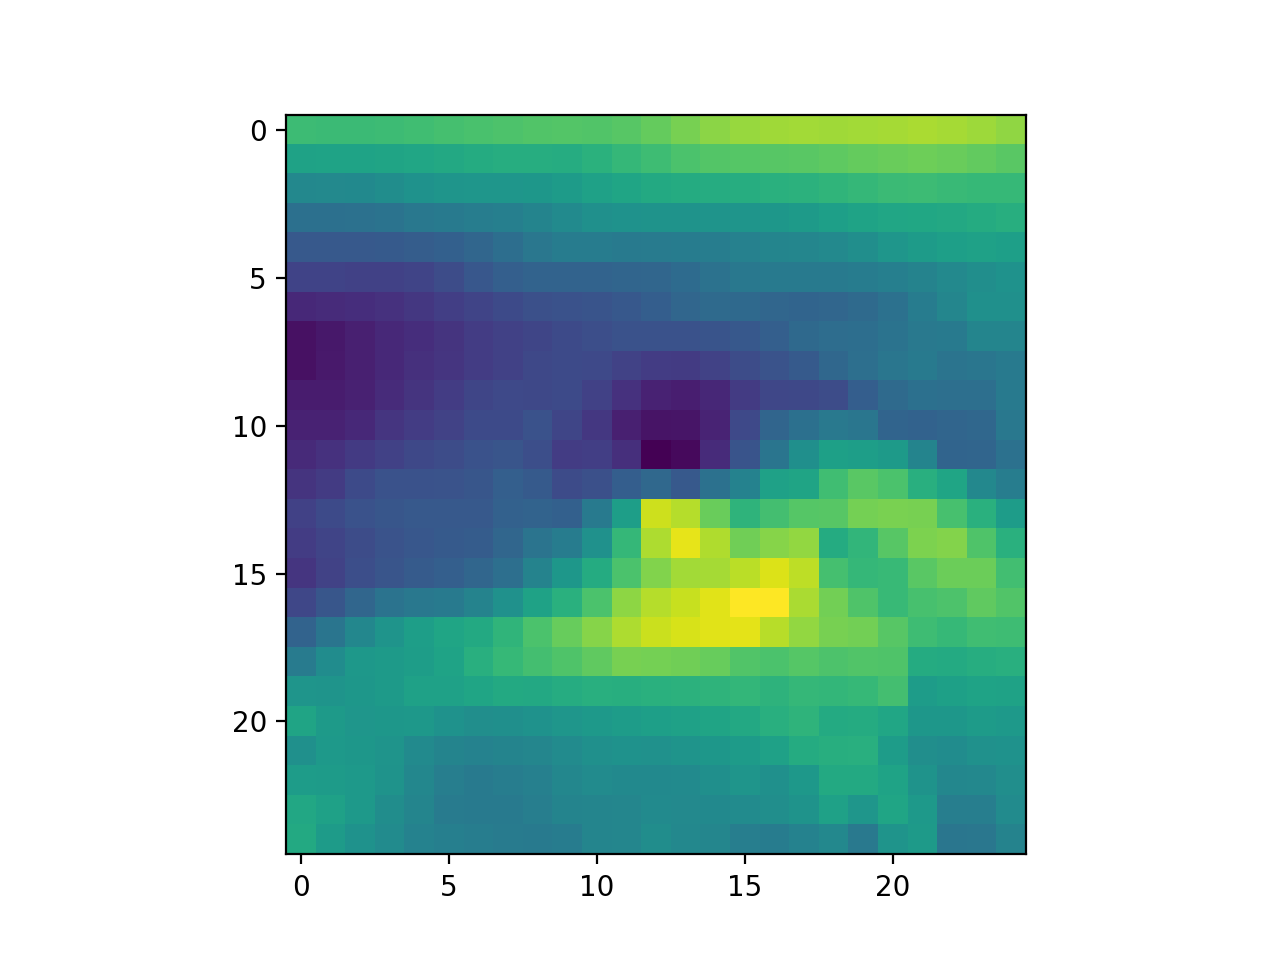

In [12]:
a = vision_data[0, 30, 0, 1]
plt.imshow(a)
plt.show()

# Transformers like

In [17]:
"""
from utils import models
import imp
imp.reload(models)

classic_configuration = (
('conv', 64), 
('conv', 64), 
('maxpool', None),
('conv', 256),
('maxpool', None),
('flatten', 256*4*4),
('linear', 256), 
('fc', 10)
)

mod = models.CNNEncoder(n_in=3*3, 
                n_out = 10, 
                hidden_configuration=classic_configuration)

print(mod)

batch_size = 10
#test_tensor = torch.Tensor(vision_data[:batch_size,:]).resize(batch_size, 9, 25,25)
test_tensor = torch.Tensor(vision_data[:batch_size,:]).resize(batch_size, 60, 9, 25,25).transpose(0,1)
print(test_tensor.size())
#print(mod(test_tensor), mod(test_tensor).size())
rnn1 = nn.GRUCell(10, 20)
rnn2 = nn.GRUCell(20, 2)
#input = torch.randn(6, 3, 10)
#>>> hx = torch.randn(3, 20)
#>>> output = []
#>>> for i in range(6):
#        hx = rnn(input[i], hx)
#        output.append(hx)
hx = torch.randn(batch_size,20)
hy = torch.randn(batch_size,2)
outputs = []
predict_at = 8
for i in range(60):
    test_tensor = torch.Tensor(vision_data[:batch_size,i]).resize(batch_size, 9, 25,25)
    transformed_image = mod(test_tensor)
    hx = rnn1(transformed_image, hx)
    print(transformed_image.size(), hx.size())
    hy = rnn2(hx, hy)
    if i >= predict_at:
        outputs.append(hy)
    
out = torch.stack(outputs).transpose(1,0)
out.size()
"""

"\nfrom utils import models\nimport imp\nimp.reload(models)\n\nclassic_configuration = (\n('conv', 64), \n('conv', 64), \n('maxpool', None),\n('conv', 256),\n('maxpool', None),\n('flatten', 256*4*4),\n('linear', 256), \n('fc', 10)\n)\n\nmod = models.CNNEncoder(n_in=3*3, \n                n_out = 10, \n                hidden_configuration=classic_configuration)\n\nprint(mod)\n\nbatch_size = 10\n#test_tensor = torch.Tensor(vision_data[:batch_size,:]).resize(batch_size, 9, 25,25)\ntest_tensor = torch.Tensor(vision_data[:batch_size,:]).resize(batch_size, 60, 9, 25,25).transpose(0,1)\nprint(test_tensor.size())\n#print(mod(test_tensor), mod(test_tensor).size())\nrnn1 = nn.GRUCell(10, 20)\nrnn2 = nn.GRUCell(20, 2)\n#input = torch.randn(6, 3, 10)\n#>>> hx = torch.randn(3, 20)\n#>>> output = []\n#>>> for i in range(6):\n#        hx = rnn(input[i], hx)\n#        output.append(hx)\nhx = torch.randn(batch_size,20)\nhy = torch.randn(batch_size,2)\noutputs = []\npredict_at = 8\nfor i in range(60):\n

In [86]:
model = torch.hub.load('huggingface/pytorch-transformers', 
                       'modelForSequenceClassification', 
                       'bert-base-uncased')    # Download model and configuration from S3 and cache.

Downloading: "https://github.com/huggingface/pytorch-transformers/archive/master.zip" to /Users/theoguenais/.cache/torch/hub/master.zip
Epochs:   0%|          | 0/1 [1:19:40<?, ?it/s]






100%|██████████| 361/361 [00:00<00:00, 92540.26B/s][A






  0%|          | 0/440473133 [00:00<?, ?B/s]





  0%|          | 52224/440473133 [00:00<14:36, 502289.28B/s]





  0%|          | 174080/440473133 [00:00<12:36, 581947.10B/s]





  0%|          | 313344/440473133 [00:00<11:08, 658193.41B/s]





  0%|          | 399360/440473133 [00:00<10:50, 676875.31B/s]





  0%|          | 470016/440473133 [00:00<12:10, 602381.91B/s]





  0%|          | 609280/440473133 [00:00<10:27, 700544.07B/s]





  0%|          | 696320/440473133 [00:00<10:22, 706260.83B/s]





  0%|          | 800768/440473133 [00:01<09:46, 749541.15B/s]





  0%|          | 905216/440473133 [00:01<08:56, 818685.41B/s]





  0%|          | 1061888/440473133 [00:01<07:45, 943604.18B/s]





  0%|          | 1218560/44047

 12%|█▏        | 52048896/440473133 [00:25<02:21, 2751769.53B/s]





 12%|█▏        | 52333568/440473133 [00:25<02:28, 2609033.59B/s]





 12%|█▏        | 52602880/440473133 [00:25<02:57, 2184656.70B/s]





 12%|█▏        | 52839424/440473133 [00:26<03:39, 1767912.51B/s]





 12%|█▏        | 53042176/440473133 [00:26<03:41, 1751925.47B/s]





 12%|█▏        | 53463040/440473133 [00:26<03:02, 2123753.19B/s]





 12%|█▏        | 53757952/440473133 [00:26<02:54, 2213171.47B/s]





 12%|█▏        | 54014976/440473133 [00:26<03:06, 2077383.92B/s]





 12%|█▏        | 54249472/440473133 [00:26<03:36, 1786715.05B/s]





 12%|█▏        | 54454272/440473133 [00:27<04:49, 1333694.29B/s]





 12%|█▏        | 54675456/440473133 [00:27<04:26, 1449340.92B/s]





 12%|█▏        | 54848512/440473133 [00:27<04:22, 1470414.86B/s]





 12%|█▏        | 55015424/440473133 [00:27<04:40, 1371763.52B/s]





 13%|█▎        | 55232512/440473133 [00:27<04:16, 1499906.04B/s]





 13%|█▎        | 553

 25%|██▌       | 110499840/440473133 [00:50<02:15, 2431268.88B/s]





 25%|██▌       | 110801920/440473133 [00:50<02:14, 2449794.70B/s]





 25%|██▌       | 111118336/440473133 [00:50<02:11, 2510862.15B/s]





 25%|██▌       | 111425536/440473133 [00:50<02:03, 2655508.51B/s]





 25%|██▌       | 111714304/440473133 [00:50<02:10, 2514131.99B/s]





 25%|██▌       | 112101376/440473133 [00:50<01:59, 2737819.27B/s]





 26%|██▌       | 112494592/440473133 [00:50<01:48, 3010032.82B/s]





 26%|██▌       | 112817152/440473133 [00:50<01:48, 3020565.73B/s]





 26%|██▌       | 113134592/440473133 [00:51<02:04, 2627285.33B/s]





 26%|██▌       | 113417216/440473133 [00:51<02:08, 2554503.38B/s]





 26%|██▌       | 113788928/440473133 [00:51<01:56, 2814694.27B/s]





 26%|██▌       | 114149376/440473133 [00:51<01:48, 3002456.77B/s]





 26%|██▌       | 114465792/440473133 [00:51<01:49, 2979923.59B/s]





 26%|██▌       | 114804736/440473133 [00:51<01:45, 3072507.68B/s]





 26%|█

 39%|███▉      | 173395968/440473133 [01:19<01:49, 2442757.27B/s]





 39%|███▉      | 173703168/440473133 [01:19<01:57, 2262558.58B/s]





 40%|███▉      | 174016512/440473133 [01:19<01:49, 2427540.74B/s]





 40%|███▉      | 174311424/440473133 [01:19<01:44, 2550059.23B/s]





 40%|███▉      | 174696448/440473133 [01:19<01:34, 2799674.05B/s]





 40%|███▉      | 175081472/440473133 [01:19<01:29, 2977753.73B/s]





 40%|███▉      | 175400960/440473133 [01:20<01:52, 2365184.28B/s]





 40%|███▉      | 175785984/440473133 [01:20<01:40, 2643955.46B/s]





 40%|███▉      | 176086016/440473133 [01:20<01:42, 2591010.11B/s]





 40%|████      | 176408576/440473133 [01:20<01:37, 2720734.83B/s]





 40%|████      | 176850944/440473133 [01:20<01:26, 3039140.64B/s]





 40%|████      | 177180672/440473133 [01:20<01:26, 3027111.04B/s]





 40%|████      | 177501184/440473133 [01:20<01:34, 2792152.54B/s]





 40%|████      | 177797120/440473133 [01:20<01:35, 2762101.19B/s]





 40%|█

 51%|█████     | 225113088/440473133 [01:47<01:23, 2586165.47B/s]





 51%|█████     | 225427456/440473133 [01:47<01:26, 2481733.11B/s]





 51%|█████▏    | 225773568/440473133 [01:47<01:20, 2676381.42B/s]





 51%|█████▏    | 226084864/440473133 [01:47<01:16, 2791678.56B/s]





 51%|█████▏    | 226387968/440473133 [01:47<01:15, 2818390.19B/s]





 51%|█████▏    | 226716672/440473133 [01:47<01:12, 2944302.65B/s]





 52%|█████▏    | 227024896/440473133 [01:48<02:53, 1230173.18B/s]





 52%|█████▏    | 227256320/440473133 [01:48<02:47, 1276143.98B/s]





 52%|█████▏    | 227460096/440473133 [01:48<02:48, 1262301.28B/s]





 52%|█████▏    | 227674112/440473133 [01:48<02:32, 1396431.03B/s]





 52%|█████▏    | 227856384/440473133 [01:49<03:11, 1112433.51B/s]





 52%|█████▏    | 228116480/440473133 [01:49<02:40, 1325509.00B/s]





 52%|█████▏    | 228362240/440473133 [01:49<02:19, 1515729.88B/s]





 52%|█████▏    | 228554752/440473133 [01:49<02:15, 1558257.16B/s]





 52%|█

 64%|██████▎   | 279840768/440473133 [02:16<01:26, 1851228.30B/s]





 64%|██████▎   | 280217600/440473133 [02:16<01:16, 2081654.52B/s]





 64%|██████▎   | 280460288/440473133 [02:16<01:15, 2131164.66B/s]





 64%|██████▎   | 280697856/440473133 [02:16<01:23, 1922050.36B/s]





 64%|██████▍   | 280911872/440473133 [02:17<01:34, 1686420.53B/s]





 64%|██████▍   | 281135104/440473133 [02:17<01:31, 1748884.38B/s]





 64%|██████▍   | 281511936/440473133 [02:17<01:17, 2047026.70B/s]





 64%|██████▍   | 281747456/440473133 [02:17<01:21, 1958353.49B/s]





 64%|██████▍   | 282052608/440473133 [02:17<01:12, 2174462.48B/s]





 64%|██████▍   | 282396672/440473133 [02:17<01:05, 2409828.28B/s]





 64%|██████▍   | 282661888/440473133 [02:17<01:11, 2218901.66B/s]





 64%|██████▍   | 282990592/440473133 [02:17<01:04, 2457779.35B/s]





 64%|██████▍   | 283258880/440473133 [02:18<01:09, 2255044.35B/s]





 64%|██████▍   | 283543552/440473133 [02:18<01:06, 2371567.29B/s]





 64%|█

 74%|███████▎  | 323869696/440473133 [02:45<01:14, 1557057.57B/s]





 74%|███████▎  | 324069376/440473133 [02:46<01:09, 1666861.89B/s]





 74%|███████▎  | 324247552/440473133 [02:46<01:14, 1559568.63B/s]





 74%|███████▎  | 324552704/440473133 [02:46<01:12, 1606956.23B/s]





 74%|███████▎  | 324720640/440473133 [02:46<01:15, 1539243.85B/s]





 74%|███████▍  | 324880384/440473133 [02:46<01:17, 1500408.33B/s]





 74%|███████▍  | 325035008/440473133 [02:46<01:29, 1292987.91B/s]





 74%|███████▍  | 325172224/440473133 [02:46<01:35, 1210510.95B/s]





 74%|███████▍  | 325300224/440473133 [02:47<02:54, 658575.96B/s] 





 74%|███████▍  | 325399552/440473133 [02:47<05:12, 368429.28B/s]





 74%|███████▍  | 325552128/440473133 [02:47<04:09, 459725.18B/s]





 74%|███████▍  | 325732352/440473133 [02:48<03:18, 577029.53B/s]





 74%|███████▍  | 325896192/440473133 [02:49<05:54, 323414.90B/s]





 74%|███████▍  | 326076416/440473133 [02:49<04:28, 425614.49B/s]





 74%|██████

 84%|████████▎ | 368598016/440473133 [03:14<00:49, 1452561.90B/s]





 84%|████████▎ | 368795648/440473133 [03:14<00:46, 1552291.67B/s]





 84%|████████▍ | 369100800/440473133 [03:14<00:39, 1797045.76B/s]





 84%|████████▍ | 369331200/440473133 [03:14<00:36, 1923723.61B/s]





 84%|████████▍ | 369625088/440473133 [03:14<00:33, 2130614.26B/s]





 84%|████████▍ | 370001920/440473133 [03:14<00:29, 2402017.71B/s]





 84%|████████▍ | 370280448/440473133 [03:15<01:18, 895882.23B/s] 





 84%|████████▍ | 371079168/440473133 [03:15<00:56, 1221074.55B/s]





 85%|████████▍ | 372557824/440473133 [03:15<00:40, 1676962.68B/s]





 85%|████████▍ | 373215232/440473133 [03:16<00:42, 1569801.07B/s]





 85%|████████▍ | 373715968/440473133 [03:16<00:41, 1589884.78B/s]





 85%|████████▍ | 374116352/440473133 [03:16<00:36, 1797618.52B/s]





 85%|████████▌ | 374473728/440473133 [03:16<00:34, 1893315.39B/s]





 85%|████████▌ | 374884352/440473133 [03:16<00:29, 2205932.09B/s]





 85%|█

 97%|█████████▋| 425199616/440473133 [03:41<00:07, 1945984.97B/s]





 97%|█████████▋| 425408512/440473133 [03:41<00:08, 1750639.80B/s]





 97%|█████████▋| 425789440/440473133 [03:41<00:07, 2066530.46B/s]





 97%|█████████▋| 426029056/440473133 [03:41<00:07, 2049187.74B/s]





 97%|█████████▋| 426257408/440473133 [03:42<00:08, 1768961.30B/s]





 97%|█████████▋| 426477568/440473133 [03:42<00:07, 1852515.82B/s]





 97%|█████████▋| 426739712/440473133 [03:42<00:06, 2016363.20B/s]





 97%|█████████▋| 426957824/440473133 [03:42<00:06, 2049581.46B/s]





 97%|█████████▋| 427214848/440473133 [03:42<00:06, 2146408.76B/s]





 97%|█████████▋| 427559936/440473133 [03:42<00:05, 2420595.12B/s]





 97%|█████████▋| 427821056/440473133 [03:42<00:05, 2397005.74B/s]





 97%|█████████▋| 428073984/440473133 [03:42<00:05, 2391610.35B/s]





 97%|█████████▋| 428341248/440473133 [03:42<00:04, 2468169.70B/s]





 97%|█████████▋| 428673024/440473133 [03:43<00:04, 2632546.37B/s]





 97%|█

In [98]:
model.bert.embeddings

BertEmbeddings(
  (word_embeddings): Embedding(30522, 768, padding_idx=0)
  (position_embeddings): Embedding(512, 768)
  (token_type_embeddings): Embedding(2, 768)
  (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [23]:
"""
#model.bert.embeddings.word_embeddings
#for x_ in x_viz.unbind(1):
#    print(x_.size())
##for x_ in x_viz.unbind(1):
#    print(x_.size())
    #.size()
#for x_ in x_viz.unfold(1):
#    print(x_.size())
from utils import models
imp.reload(models)
encoder_config = (
('conv', 64), 
('conv', 64), 
('maxpool', None),
('conv', 256),
('maxpool', None),
('flatten', 256*4*4),
('linear', 512)
)


#I put an assertion check to make sure we specify the correct n_out
encoder = models.CNNEncoder(n_in=3*3, 
                n_out = 512, 
                hidden_configuration=encoder_config)

transo = models.TRANSFORMER(encoder=encoder, 
                d_model=512, 
                n_head=8, 
                n_transformer_layer=4)

#transfo(x_viz)
#x_viz.size()
#out = []
for x_ in x_viz.unbind(1):
    print(x_.size())
    out.append(encoder(x_))
torch.stack(out).transpose(0,1).size()
x_viz.unbind(1)[0].size()
#vars(transfo)
#print(encoder)


#ONE POSSIBILITY
before = x_viz.size()
print(x_viz.size())
encoder(x_viz.flatten(end_dim=1)).resize(before[0],before[1], 512)
"""

"\n#model.bert.embeddings.word_embeddings\n#for x_ in x_viz.unbind(1):\n#    print(x_.size())\n##for x_ in x_viz.unbind(1):\n#    print(x_.size())\n    #.size()\n#for x_ in x_viz.unfold(1):\n#    print(x_.size())\nfrom utils import models\nimp.reload(models)\nencoder_config = (\n('conv', 64), \n('conv', 64), \n('maxpool', None),\n('conv', 256),\n('maxpool', None),\n('flatten', 256*4*4),\n('linear', 512)\n)\n\n\n#I put an assertion check to make sure we specify the correct n_out\nencoder = models.CNNEncoder(n_in=3*3, \n                n_out = 512, \n                hidden_configuration=encoder_config)\n\ntranso = models.TRANSFORMER(encoder=encoder, \n                d_model=512, \n                n_head=8, \n                n_transformer_layer=4)\n\n#transfo(x_viz)\n#x_viz.size()\n#out = []\nfor x_ in x_viz.unbind(1):\n    print(x_.size())\n    out.append(encoder(x_))\ntorch.stack(out).transpose(0,1).size()\nx_viz.unbind(1)[0].size()\n#vars(transfo)\n#print(encoder)\n\n\n#ONE POSSIBILIT

In [24]:
"""
encoder = models.CNNEncoder(n_in=3*3, 
                n_out = 512, 
                hidden_configuration=encoder_config)

transo = models.TRANSFORMER(encoder=encoder, 
                d_model=512, 
                n_head=8, 
                n_transformer_layer=4)
hasattr(transfo,'encodercnn')
"""

"\nencoder = models.CNNEncoder(n_in=3*3, \n                n_out = 512, \n                hidden_configuration=encoder_config)\n\ntranso = models.TRANSFORMER(encoder=encoder, \n                d_model=512, \n                n_head=8, \n                n_transformer_layer=4)\nhasattr(transfo,'encodercnn')\n"

In [203]:
#Example of a transformer without positional encoding
#def HTransformer(torch.nn.Module):
transfo = nn.Sequential(*[nn.TransformerEncoderLayer(d_model=512, nhead=8)]*3)
x_in = torch.randn(10, 199, 512)
#transfo(x_in)#.size()
#help(nn.TransformerEncoderLayer)
import warnings
x=2
if x == 2:
    warnings.warn('careful', UserWarning)
else:
    pass
transfo

Sequential(
  (0): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): Linear(in_features=512, out_features=512, bias=True)
    )
    (linear1): Linear(in_features=512, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=512, bias=True)
    (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (1): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): Linear(in_features=512, out_features=512, bias=True)
    )
    (linear1): Linear(in_features=512, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=512, bias=True)
    (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((512,), ep

# CNN Encoder

## Test

## ConvLSTM cell

In [38]:
c = ConvLSTM(input_dim = 9, hidden_dim=128, kernel_size=(3,3), num_layers=1, batch_first=True, bias = True)

In [39]:
s = vision_data.shape
v = vision_data.reshape(s[0], s[1], s[2]*s[3], s[4], s[5])
v = torch.Tensor(v)

In [40]:
c.eval()
outputs, last_states = c(v[0][:10].unsqueeze(0))

In [41]:
outputs[0][0].shape

torch.Size([10, 128, 25, 25])

# Check the training curriculum

In [1]:
!pwd
import netCDF4
import cdsapi
#TRY NEW WAY TO DEFINE FUNC
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from utils import data_processing
from utils import utils_vision_data
import warnings; warnings.simplefilter('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import time 

/Users/theoguenais/Desktop/Harvard/Harvard-Classes/hurricast


In [3]:
!ls ./data

ibtracs.last3years.list.v04r00.csv y.pt


In [8]:
y = torch.load('./data/y.pt')
vision_data = torch.load('./data/vision_data.pt')
train_test_split=0.8

In [21]:
import run
import imp 
imp.reload(run)
tensor_train, tensor_test =run.Prepro.process(
            vision_data, y, 
            train_test_split, 
            predict_at=8, 
            window_size=8)

New dataset and corresponding sizes:  torch.Size([3735, 8, 9, 25, 25]) torch.Size([3735, 8, 6]) torch.Size([3735, 6])
3182 636.3999999999999 636


In [25]:
tensor_train[0].size()

torch.Size([2546, 8, 9, 25, 25])

In [27]:
tensor_test[0].size()

torch.Size([636, 8, 9, 25, 25])

In [40]:
train_ds = torch.utils.data.TensorDataset(*tensor_train)
train_loader = torch.utils.data.DataLoader(train_ds, 
                                            batch_size=10, 
                                            shuffle=True)

In [42]:
test_ds = torch.utils.data.TensorDataset(*tensor_test)
test_loader = torch.utils.data.DataLoader(test_ds, 
                                            batch_size=10, 
                                            shuffle=False)


In [30]:
import setup
encoder_config = setup.encoder_config

In [33]:
from utils import models
encoder = models.CNNEncoder(n_in=3*3,
                            n_out=128,
                            hidden_configuration=encoder_config)

In [34]:
model = models.LINEARTransform(encoder)

In [37]:
optimizer = torch.optim.Adam(model.parameters(), 
                                lr=0.001)
import torch.nn as nn 

In [38]:
model, optimizer, loss = run.train(model,
                                optimizer=optimizer,
                                loss_fn=nn.MSELoss(),
                                n_epochs=1,
                                train_loader=train_loader,
                                args={},
                                scheduler=None,
                                l2_reg=0.2)

NameError: name 'train_loader' is not defined

In [16]:
#args.batch_size=10
#train_loader = DataLoader(train_ds, batch_size=args.batch_size, shuffle=True)
#test_loader = torch.utils.data.DataLoader(test_ds, batch_size=args.batch_size, shuffle=False)

In [21]:
 _,_,tgt_dis, _= train_tensors
tgt_dis.size()
sum_ = torch.sum(tgt_dis == 0,axis=1)
tgt_dis[torch.nonzero(sum_)] #FIRST PROBLEM? No

tensor([[[ 0.0000, -0.2210]],

        [[ 0.0000, -0.1790]],

        [[ 0.0000,  0.5000]],

        [[ 0.0000, -0.5500]],

        [[ 0.0000, -0.5500]],

        [[ 0.1000,  0.0000]],

        [[ 0.4845,  0.0000]],

        [[ 0.0000, -0.1000]],

        [[ 0.0000, -0.1650]],

        [[ 0.0000, -0.1350]],

        [[ 0.0000, -0.1080]],

        [[ 0.0000, -0.0920]],

        [[ 0.0000, -0.1000]],

        [[ 0.0000, -0.2000]],

        [[ 0.0000,  0.3420]],

        [[ 0.0000,  0.3580]],

        [[ 0.0000, -0.4580]]])

In [4]:
vision_data = np.load("data/vision_data.npy", allow_pickle=True)
#np.save("data/y.npy", y, allow_pickle=True)
y = np.load("data/y.npy", allow_pickle=True)

import run 
from run import Prepro
#train_data = prepro.create_targets(8,8)
train_tensors, test_tensors = Prepro.process(vision_data, 
                                y, 
                                0.8,
                                predict_at=8, 
                                window_size=8)

New dataset and corresponding sizes (null elements included):
X_vision torch.Size([3735, 8, 9, 25, 25])
X_stat torch.Size([3735, 8, 6])
target_displacement torch.Size([3735, 8, 2])
target_intensity torch.Size([3735])
Keeping 3143 samples out of the initial 3735.
Reshaping the displacement target...


In [8]:
#y[0].shape
from utils import models
import setup
encoder_config = setup.encoder_config #Load pre-defined config
encoder = models.CNNEncoder(n_in=3*3,
                                n_out=128,
                                hidden_configuration=encoder_config)
encoder

CNNEncoder(
  (activation): ReLU()
  (layers): Sequential(
    (0): Conv2d(9, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1))
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Flatten()
    (12): Linear(in_features=4096, out_features=256, bias=True)
    (13): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Linear(in_features=256, out_features=128, bias=True)
  )
)

In [10]:
encdec = models.ENCDEC(encoder, n_in_decoder=128+6, n_out_decoder=128, 
                       hidden_configuration_decoder=models.encdec_config, window_size=8)

In [56]:
import imp
imp.reload(models)
from utils import models
model = models.WRAPPER(model=encdec, n_in=128, n_out=2, n_per_hidden_layer=None)

In [57]:
model(train_tensors[0][:2], train_tensors[1][:2])

torch.Size([2, 128])


tensor([[0.0134, 0.1845],
        [0.0140, 0.1831]], grad_fn=<AddmmBackward>)

In [58]:
lineartransform = models.LINEARTransform(encoder, n_in_decoder=128, n_out_decoder=128, 
                       hidden_configuration_decoder=models.lineartransform_config, window_size=8)
model = models.WRAPPER(model=lineartransform, n_in=128, n_out=2, n_per_hidden_layer=None)
model(train_tensors[0][:2], train_tensors[1][:2])


HERE torch.Size([2, 1024])
HERE torch.Size([2, 128])
torch.Size([2, 128])


tensor([[-0.0932,  0.1905],
        [ 0.0649,  0.2569]], grad_fn=<AddmmBackward>)

In [69]:







model = create_model('CNNEncoder', encoder_args, 'ENCDEC', encdec_args, wrapper_args)
model(train_tensors[0][:2], train_tensors[1][:2])


torch.Size([2, 128])


tensor([[-0.2735,  0.1984],
        [-0.2705,  0.2037]], grad_fn=<AddmmBackward>)

In [70]:
encoder_args = dict(n_in=3*3,
                n_out=128,
                hidden_configuration=encoder_config)



wrapper_args = dict(n_in=128,
                   n_out=2,
                   n_per_hidden_layer=None)
model = create_model('CNNEncoder', encoder_args, 'ENCDEC', encdec_args, wrapper_args)
model(train_tensors[0][:2], train_tensors[1][:2])

torch.Size([2, 128])


tensor([[-0.0023,  0.1161],
        [-0.0034,  0.1169]], grad_fn=<AddmmBackward>)

In [29]:

#y[0] is the timestamp

#y[1] is latitude

#y[2] is longitude

#y[3] is windspeed (intensity)

#y[4] is pressure

#y[5] is the latitude displacement with previous timestep

#y[6] is longitude displacement with previous timestep

In [83]:
mod = models.TRANSFORMER(encoder, 
d_model=512, 
n_head=2, 
n_transformer_layer=4)

In [84]:
out1 = mod(train_tensors[0][:2])
out1.size()

torch.Size([2, 8, 128])

In [93]:
#mod.transformer_layers(out1)
#test_ = nn.TransformerEncoderLayer(
#                                d_model=128, 
#                                nhead=4, 
#                                num_encoder_layers=10)
#test_(out1)
encoder_layer = nn.TransformerEncoderLayer(d_model=128, nhead=8)
transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=6)
transformer_encoder(out1)

tensor([[[ 0.9488,  0.1605, -1.1573,  ...,  1.4129, -0.2416,  0.0150],
         [ 1.4980,  1.1278, -1.0903,  ...,  1.3054, -0.3963,  0.9656],
         [ 0.5874,  1.1322, -0.7171,  ...,  1.2839, -0.2261,  0.2421],
         ...,
         [ 0.4675,  0.6165, -0.7097,  ...,  0.8975, -1.0311, -0.0881],
         [ 0.9942,  0.1439, -1.2128,  ...,  0.9433, -0.5798, -0.1927],
         [ 0.9739,  0.4988, -0.6061,  ...,  0.1809, -0.8792, -0.3321]],

        [[ 1.0828,  0.5426, -0.7235,  ...,  0.5639, -0.5553, -0.5896],
         [ 1.3273, -0.8762,  0.2058,  ...,  0.4332, -0.8788,  0.3826],
         [ 1.0987,  0.3227, -0.7928,  ...,  0.6755, -0.2165,  0.6121],
         ...,
         [ 0.6588, -0.0494, -0.4853,  ...,  1.1213,  0.0663,  0.7339],
         [ 0.8721,  0.4184,  0.7460,  ...,  0.6402, -0.7117, -0.0211],
         [ 1.1847,  0.4800, -0.9690,  ...,  0.3860, -1.6117,  0.0486]]],
       grad_fn=<NativeLayerNormBackward>)

In [35]:
list(map(lambda t: t.size(), train_tensors))
train_tensors[-1].size()

torch.Size([2515])

In [115]:
imp.reload(models)
from utils import models

import setup
encoder_config = setup.encoder_config #Load pre-defined config
encoder = models.CNNEncoder(n_in=3*3,
                                n_out=128,
                                hidden_configuration=encoder_config)

transformer_config = {'d_model': 128 + 6,
                      'nhead': 2,
                      'num_layers': 4
                      }
model = models.TRANSFORMER(encoder, 128+6, 128+6, transformer_config, 8)

final_model = models.WRAPPER(model, 128+6, 2, None)
#model()
#model(train_tensors[0][:2], train_tensors[1][:2])
#final_model(train_tensors[0][:2], train_tensors[1][:2])

OUT torch.Size([2, 8, 128]) torch.Size([2, 8, 6])
OUT torch.Size([2, 8, 134])
OUT torch.Size([2, 8, 128]) torch.Size([2, 8, 6])
OUT torch.Size([2, 8, 134])


tensor([[[0.6993, 0.8711],
         [0.6042, 0.6670],
         [0.6198, 0.6602],
         [0.5723, 0.6022],
         [0.4455, 0.3874],
         [0.5618, 0.5678],
         [0.6714, 0.5596],
         [0.8179, 0.4560]],

        [[0.6628, 0.8588],
         [0.4791, 0.2388],
         [0.7411, 0.4369],
         [0.7124, 0.5927],
         [0.6477, 0.6539],
         [0.6863, 0.4698],
         [0.5147, 0.5633],
         [0.6488, 0.6585]]], grad_fn=<AddBackward0>)

In [27]:
from utils import models
import setup
encoder_config = setup.encoder_config #Load pre-defined config
encoder = models.CNNEncoder(n_in=3*3,
                                n_out=128,
                                hidden_configuration=encoder_config)
model = models.LINEARTransform(encoder, target_intensity=True)
model

LINEARTransform(
  (encoder): CNNEncoder(
    (activation): ReLU()
    (layers): Sequential(
      (0): Conv2d(9, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1))
      (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU()
      (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (11): Flatten()
      (12): Linear(in_features=4096, out_features=256, bias=True)
      (13): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (14): ReLU()
      (15): Linear(in_f

torch.Size([2515])


(array([ 74., 103., 275., 191., 169., 311., 209., 239., 114., 117., 202.,
        131., 129.,  92.,  54.,  40.,  26.,  20.,   7.,  12.]),
 array([ 15.,  22.,  29.,  36.,  43.,  50.,  57.,  64.,  71.,  78.,  85.,
         92.,  99., 106., 113., 120., 127., 134., 141., 148., 155.],
       dtype=float32),
 <a list of 20 Patch objects>)

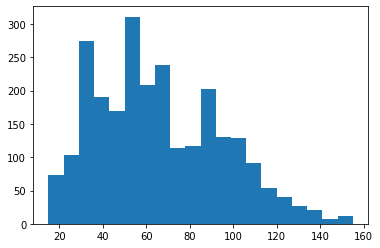

In [42]:
import matplotlib.pyplot as plt
print(train_tensors[-1].size())
plt.hist(train_tensors[-1], bins=20)

In [44]:
x_viz = train_tensors[0][:2]
x_stat = train_tensors[1][:2]
tgt_velocity = train_tensors[-1][:2]

In [49]:
out = model(x_viz, x_stat)
out.size()

torch.Size([2, 1])

In [50]:
tgt_velocity.size()

torch.Size([2])

In [48]:
loss= torch.nn.MSELoss()

In [51]:
loss(out, tgt_velocity)

tensor(1224.0791, grad_fn=<MseLossBackward>)

In [62]:
train_tensors[-1].mean()

tensor(65.5545)

In [68]:
p= Prepro(vision_data, 
                                y, 
                                0.8,
                                predict_at=8, 
                                window_size=8)

In [69]:
p.y.size()

torch.Size([83, 60, 6])

In [71]:
#p.y.flatten(end_dim=1).size()

torch.Size([4980, 6])

In [95]:
#Targets
X_vision = p.vision_data[:, :-8].unfold(1, 8, 1)
X_stat = p.y[:, :-8].unfold(1, 8, 1)
print(X_vision.size(), X_stat.size())

torch.Size([83, 45, 3, 3, 25, 25, 8]) torch.Size([83, 45, 6, 8])


In [94]:
#Displacement
tgt_dis = p.y[:, 8:].unfold(1, 8, 1).sum(axis=-1)
#tgt_dis = tgt_dis.flatten(end_dim=1)
print(tgt_dis[:, :, -2:].size())

torch.Size([83, 45, 2])


In [98]:
old_tgt_dis = p.y[:, 15:, -2:]
old_tgt_dis.size()

torch.Size([83, 45, 2])

In [100]:
tgt_velocity = p.y[:, 15:]#.flatten(end_dim=1)
tgt_velocity.size()

torch.Size([83, 45, 6])

In [13]:
import run 
import imp 
imp.reload(run)
train_tensors, test_tensors = Prepro.process(vision_data, 
                                y, 
                                0.8,
                                predict_at=8, 
                                window_size=8)
for x in train_tensors:
    print(x.size())
    


torch.Size([3735, 6])
New dataset and corresponding sizes:
X_vision torch.Size([3735, 8, 9, 25, 25])
X_stat torch.Size([3735, 8, 6])
target_displacement torch.Size([3735, 2])
target_intensity torch.Size([3735])
torch.Size([2698, 8, 9, 25, 25])
torch.Size([2698, 8, 6])
torch.Size([2698, 2])
torch.Size([2698])


In [12]:
train_tensors[-2]-train_tensors[-2].mean(axis=0)

tensor([[-1.4969e+00, -5.9908e-01],
        [-1.5694e+00, -3.2108e-01],
        [-1.5969e+00,  9.1797e-04],
        ...,
        [-2.8233e+00,  2.2672e+01],
        [-5.0174e+00,  1.7720e+01],
        [-5.8969e+00,  1.5301e+01]])

In [22]:
from torch.utils.tensorboard import SummaryWriter
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('results/results_0')

In [21]:
!ls results/results_0

args.json


In [25]:
!tensorboard --logdir=results

TensorFlow installation not found - running with reduced feature set.
TensorBoard 1.15.0 at http://dhcp-10-250-225-44.harvard.edu:6006/ (Press CTRL+C to quit)
^C


In [31]:
writer.add_graph(model, (train_tensors[0][:2], train_tensors[1][:2]))

In [ ]:
writer.add_scalar('training loss',
                            running_loss / 1000,
                            epoch * len(trainloader) + i)

In [48]:
import json
model.__str__()

"(('conv', 64), ('conv', 64), ('maxpool', None), ('conv', 256), ('maxpool', None), ('flatten', 4096), ('linear', 256), ('fc', 128))" LINEARTransform(
  (encoder): CNNEncoder(
    (activation): ReLU()
    (layers): Sequential(
      (0): Conv2d(9, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1))
      (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU()
      (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (11): Flatten()
      (12): Linear(in_features=4096, out_features=256, bias=True)
  

In [49]:
x = "{}".format('STH')

In [53]:
x = train_tensors[-2][:10]
y = train_tensors[-2][10:20]
z =train_tensors[-2][20:30]

In [54]:
l = [x,y,z]

In [56]:
torch.cat(l).size()

torch.Size([30, 2])

In [60]:
torch.norm(torch.cat(l), p=2, dim=1).size()

torch.Size([30])

In [3]:
vision_data = np.load("data/vision_data.npy", allow_pickle=True)
#np.save("data/y.npy", y, allow_pickle=True)
y = np.load("data/y.npy", allow_pickle=True)

import run 
from run import Prepro
import imp
imp.reload(run)
#train_data = prepro.create_targets(8,8)
train_tensors, test_tensors = Prepro.process(vision_data, 
                                y, 
                                0.8,
                                predict_at=8, 
                                window_size=8)

New dataset and corresponding sizes:
X_vision torch.Size([3735, 8, 9, 25, 25])
X_stat torch.Size([3735, 8, 6])
target_displacement torch.Size([3735, 6, 2])
target_intensity torch.Size([3735])
REMOVING ZEROS torch.Size([3735, 8, 9, 25, 25]) torch.Size([3735, 8, 6]) torch.Size([3735, 6, 2]) torch.Size([3735])
torch.Size([3735, 2])


IndexError: The shape of the mask [3735, 2] at index 1does not match the shape of the indexed tensor [3735, 8, 9, 25, 25] at index 1

In [4]:
prepro = 

array([[['2016-01-08 09:00:00', 6.38753, -171.692, ..., 995.5, 0.0, 0.0],
        ['2016-01-08 12:00:00', 6.8, -172.0, ..., 994.0,
         0.4124699999999999, -0.3079999999999927],
        ['2016-01-08 15:00:00', 7.03746, -172.215, ..., 994.0,
         0.23746000000000045, -0.2150000000000034],
        ...,
        ['2016-01-15 12:00:00', 1.0, -173.7, ..., 1005.0,
         -0.06750999999999996, -0.23699999999999477],
        [0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        [0, 0.0, 0.0, ..., 0.0, 0.0, 0.0]],

       [['2016-01-07 12:00:00', 28.7, -73.8, ..., 997.0, 0.0, 0.0],
        ['2016-01-07 15:00:00', 29.3268, -73.2238, ..., 992.0,
         0.6267999999999994, 0.5762],
        ['2016-01-07 18:00:00', 30.0, -72.5, ..., 987.0,
         0.6732000000000014, 0.7237999999999971],
        ...,
        ['2016-01-14 15:00:00', 31.6574, -28.3125, ..., 981.0,
         0.8573999999999984, 0.3874999999999993],
        ['2016-01-14 18:00:00', 32.5, -28.0, ..., 981.0,
         0.8426000000000009, 0.

In [5]:
p = Prepro(vision_data, 
                y, 
                0.9,
                predict_at=8, 
                window_size=8)

In [87]:
predict_at=8
window_size=8
target_displacement = p.y[:, window_size:].unfold(1, predict_at, 1)
target_displacement.size()


torch.Size([83, 45, 6, 8])

In [88]:
target_displacement = target_displacement.permute(0,1,3,2)

In [89]:
target_displacement.size()

torch.Size([83, 45, 8, 6])

In [90]:
tgt_displacement = torch.index_select(target_displacement,
                                                 dim=-1,
                                                 index=torch.tensor([target_displacement.size(-1)-2,
                                                                     target_displacement.size(-1)-1]))
tgt_displacement.size()

torch.Size([83, 45, 8, 2])

In [91]:
tgt_displacement = tgt_displacement.flatten(end_dim=1)
tgt_displacement.size()


torch.Size([3735, 8, 2])

In [92]:
good_indices = torch.sum(tgt_displacement == 0, axis=-1) != 2

In [93]:
good_indices.size()

torch.Size([3735, 8])

In [94]:
(tgt_displacement[44] == 0).sum(axis=1)

tensor([0, 0, 0, 0, 0, 0, 2, 2])

In [95]:
for u in torch.sum(tgt_displacement==0, axis=(-2,-1)):
    print(u)

tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(2)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(2)
tensor(4)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)


tensor(0)
tensor(0)
tensor(2)
tensor(4)
tensor(6)
tensor(8)
tensor(10)
tensor(12)
tensor(14)
tensor(16)
tensor(16)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(2)
tensor(4)
tensor(6)
tensor(8)
tensor(10)
tensor(12)
tensor(14)
tensor(16)
tensor(16)
tensor(16)
tensor(16)
tensor(16)
tensor(16)
tensor(16)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(2)
tensor(4)
tensor(6)
tensor(8)
tensor(10)
tensor(12)
tensor(14)
tensor(16)
tensor(16)
tensor(16)
tensor(16)
tensor(16)
tensor(16)
tensor(16)
tensor(16)
tensor(16)
tensor(16)
te

tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(2)
tensor(4)
tensor(6)
tensor(8)
tensor(10)
tensor(12)
tensor(14)
tensor(16)
tensor(16)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tenso

tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)


In [70]:
count = 0
for u in ((tgt_displacement==0).sum(axis=-1)==2).sum(axis=-1):
    #print(u)
    if u>0:
        print(u)
        count+=1

tensor(1)
tensor(2)
tensor(1)
tensor(1)
tensor(2)
tensor(3)
tensor(4)
tensor(5)
tensor(6)
tensor(7)
tensor(8)
tensor(8)
tensor(8)
tensor(8)
tensor(8)
tensor(8)
tensor(8)
tensor(8)
tensor(8)
tensor(8)
tensor(8)
tensor(8)
tensor(8)
tensor(8)
tensor(8)
tensor(8)
tensor(8)
tensor(8)
tensor(8)
tensor(8)
tensor(8)
tensor(8)
tensor(8)
tensor(8)
tensor(8)
tensor(1)
tensor(2)
tensor(3)
tensor(4)
tensor(5)
tensor(6)
tensor(7)
tensor(8)
tensor(8)
tensor(8)
tensor(8)
tensor(8)
tensor(8)
tensor(8)
tensor(1)
tensor(2)
tensor(3)
tensor(1)
tensor(1)
tensor(2)
tensor(3)
tensor(4)
tensor(5)
tensor(1)
tensor(2)
tensor(3)
tensor(4)
tensor(5)
tensor(6)
tensor(7)
tensor(8)
tensor(8)
tensor(8)
tensor(8)
tensor(8)
tensor(8)
tensor(8)
tensor(8)
tensor(8)
tensor(8)
tensor(8)
tensor(8)
tensor(8)
tensor(8)
tensor(8)
tensor(8)
tensor(8)
tensor(8)
tensor(8)
tensor(1)
tensor(2)
tensor(3)
tensor(4)
tensor(5)
tensor(6)
tensor(7)
tensor(8)
tensor(8)
tensor(8)
tensor(8)
tensor(8)
tensor(8)
tensor(8)
tensor(8)
tensor(8)


In [97]:
((tgt_displacement==0).sum(axis=-1)==2).sum(axis=-1)>0

tensor([False, False, False,  ..., False, False, False])

In [108]:
import imp 
imp.reload(run)
from run import Prepro
out =  Prepro.process(vision_data, 
                y, 
                0.9,
                predict_at=8, 
                window_size=8)

New dataset and corresponding sizes (null elements included):
X_vision torch.Size([3735, 8, 9, 25, 25])
X_stat torch.Size([3735, 8, 6])
target_displacement torch.Size([3735, 8, 2])
target_intensity torch.Size([3735])
Keeping 3143 samples out of the initial 3735
Reshaping the displacement target


In [ ]:
for a in 

In [104]:
g_i = ((tgt_displacement==0).sum(axis=-1)==2).sum(axis=-1)>0

In [106]:
l = torch.arange(len(g_i))

In [112]:
def f(mode):
    def g(x):
        if x >2:
            print('YEs')
        else:
            print('No')
    def h(x):
        print('Neva')
    if mode =='g':
        return g
    elif mode == 'h':
        return h
    else:
        raise NotImplementedError

loss = f('h')
    
        

In [117]:
pred = {'d':[]} if False else {'i':[]}

In [118]:
pred

{'i': []}

In [129]:
list(*pred.values()).append(12)

In [134]:
pred.get('i').append(14)

In [135]:
pred

{'i': [12, 14]}

In [146]:
tuple(pred.keys())[0]

'i'

In [155]:
D = {'d':[torch.arange(10).long(), torch.ones(10).long()], 'i':[torch.arange(10).long(), torch.zeros(10).long()]}

In [156]:
list(map(torch.cat, D.values()))

[tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])]

In [158]:
new_val= list(map(torch.cat, D.values()))

In [160]:
new_D = {k: torch.cat(v) for k, v in D.items()}

In [161]:
new_D

{'d': tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 'i': tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}

In [162]:
del D['i']

In [163]:
new_d = { k : torch.cat(v) for k, v in D.items() }

In [164]:
new_d

{'d': tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])}